In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bsds300/BSDS300/iids_train.txt
/kaggle/input/bsds300/BSDS300/iids_test.txt
/kaggle/input/bsds300/BSDS300/images/test/109053.jpg
/kaggle/input/bsds300/BSDS300/images/test/156065.jpg
/kaggle/input/bsds300/BSDS300/images/test/126007.jpg
/kaggle/input/bsds300/BSDS300/images/test/76053.jpg
/kaggle/input/bsds300/BSDS300/images/test/134035.jpg
/kaggle/input/bsds300/BSDS300/images/test/101085.jpg
/kaggle/input/bsds300/BSDS300/images/test/175043.jpg
/kaggle/input/bsds300/BSDS300/images/test/175032.jpg
/kaggle/input/bsds300/BSDS300/images/test/85048.jpg
/kaggle/input/bsds300/BSDS300/images/test/271035.jpg
/kaggle/input/bsds300/BSDS300/images/test/157055.jpg
/kaggle/input/bsds300/BSDS300/images/test/103070.jpg
/kaggle/input/bsds300/BSDS300/images/test/123074.jpg
/kaggle/input/bsds300/BSDS300/images/test/197017.jpg
/kaggle/input/bsds300/BSDS300/images/test/41033.jpg
/kaggle/input/bsds300/BSDS300/images/test/86068.jpg
/kaggle/input/bsds300/BSDS300/images/test/45096.jpg
/kaggle/input/b

In [2]:
!nvidia-smi

Fri May 16 15:49:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed_all(42)

# ----------------------------- #
#     CUSTOM BSDS300 DATASET
# ----------------------------- #
from torchvision.transforms import ToTensor, Resize, Compose, GaussianBlur
from PIL import Image

class BSDS300Dataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.low_quality_transform = Compose([
            Resize((256, 256)),
            GaussianBlur(kernel_size=5),
            ToTensor()
        ])
        self.high_quality_transform = Compose([
            Resize((256, 256)),
            ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = Image.open(image_path).convert("RGB")

        low_quality = self.low_quality_transform(img)
        high_quality = self.high_quality_transform(img)

        return low_quality, high_quality  # Return both as images


Using device: cuda


In [4]:
import os
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# === Setup paths ===
train_image_dir = "/kaggle/input/bsds300/BSDS300/images/train"
test_image_dir = "/kaggle/input/bsds300/BSDS300/images/test"
iids_train_path = "/kaggle/input/bsds300/BSDS300/iids_train.txt"
iids_test_path = "/kaggle/input/bsds300/BSDS300/iids_test.txt"

# === Load image IDs from text files ===
def load_image_paths(iid_file, img_dir):
    with open(iid_file, "r") as f:
        ids = [line.strip() for line in f.readlines()]
    return [os.path.join(img_dir, f"{img_id}.jpg") for img_id in ids]

train_image_paths = load_image_paths(iids_train_path, train_image_dir)
test_image_paths = load_image_paths(iids_test_path, test_image_dir)

# === Define Transform ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# === Dataset Class ===
class BSDS300Dataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.low_quality_transform = transforms.Compose([
            transforms.Resize((128, 128)),   # simulate downsampling
            transforms.Resize((256, 256))    # resize back to original
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        high_quality = self.transform(img)
        low_quality = self.low_quality_transform(img)
        low_quality = transforms.ToTensor()(low_quality)
        return low_quality, high_quality

# === Create dataset and loader ===
all_image_paths = train_image_paths + test_image_paths
dataset = BSDS300Dataset(all_image_paths, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Loaded {len(dataset)} images.")


Loaded 300 images.


In [5]:
for x, y in train_loader:
    print("Input shape:", x.shape)    # torch.Size([4, 3, 256, 256])
    print("Target shape:", y.shape)   # torch.Size([4, 3, 256, 256])
    break


Input shape: torch.Size([4, 3, 256, 256])
Target shape: torch.Size([4, 3, 256, 256])


In [6]:
# ----------------------------- #
#     BIT WITH DECODER MODEL
# ----------------------------- #
import torch
import torch.nn as nn
import timm

class BitWithDecoderUNet(nn.Module):
    def __init__(self, model_name='resnetv2_152x4_bit'):
        super(BitWithDecoderUNet, self).__init__()
        # Load pretrained BiT ResNet (features_only=True gives list of features at different stages)
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True)
        
        # Number of channels for feature maps at different stages
        feature_channels = [f['num_chs'] for f in self.backbone.feature_info]
        
        # Decoder layers with skip connections from encoder stages
        # We'll decode stepwise from deepest to shallowest feature map
        self.upconv5 = nn.ConvTranspose2d(feature_channels[-1], 512, 4, 2, 1)
        self.upconv4 = nn.ConvTranspose2d(512 + feature_channels[-2], 256, 4, 2, 1)
        self.upconv3 = nn.ConvTranspose2d(256 + feature_channels[-3], 128, 4, 2, 1)
        self.upconv2 = nn.ConvTranspose2d(128 + feature_channels[-4], 64, 4, 2, 1)
        self.upconv1 = nn.ConvTranspose2d(64 + feature_channels[-5], 32, 4, 2, 1)

        self.relu = nn.ReLU(inplace=True)
        self.out_conv = nn.Conv2d(32, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder features from backbone (list of feature maps)
        features = self.backbone(x)
        
        # Start decoding from the deepest feature
        x = self.upconv5(features[-1])
        x = self.relu(x)

        # Concatenate skip connections and decode stepwise
        x = torch.cat([x, features[-2]], dim=1)
        x = self.upconv4(x)
        x = self.relu(x)

        x = torch.cat([x, features[-3]], dim=1)
        x = self.upconv3(x)
        x = self.relu(x)

        x = torch.cat([x, features[-4]], dim=1)
        x = self.upconv2(x)
        x = self.relu(x)

        x = torch.cat([x, features[-5]], dim=1)
        x = self.upconv1(x)
        x = self.relu(x)

        # Output RGB image
        x = self.out_conv(x)
        x = self.sigmoid(x)
        return x



In [7]:
import timm
print(timm.list_models('*bit*'))

['resnetv2_50x1_bit', 'resnetv2_50x3_bit', 'resnetv2_101x1_bit', 'resnetv2_101x3_bit', 'resnetv2_152x2_bit', 'resnetv2_152x4_bit']


In [8]:
import torch
torch.cuda.empty_cache()


In [12]:

# Model creation/loading cell
student = BitWithDecoderUNet(model_name='resnetv2_152x2_bit')
teacher = BitWithDecoderUNet(model_name='resnetv2_152x4_bit')
# (or however you initialize your models)

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = student.to(device)
teacher = teacher.to(device)

# Freeze teacher model
for param in teacher.parameters():
    param.requires_grad = False

model.safetensors:   0%|          | 0.00/945M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.75G [00:00<?, ?B/s]

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=0.0, delta=0.0, perceptual_model=None):
        """
        alpha: weight for distillation loss (L2 between student and teacher)
        beta: weight for reconstruction loss (L1 between student and ground truth)
        gamma: weight for perceptual loss (optional)
        delta: weight for SSIM loss (optional)
        perceptual_model: pretrained model for perceptual loss (e.g. VGG features)
        """
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        
        self.l2 = nn.MSELoss()
        self.l1 = nn.L1Loss()
        
        self.perceptual_model = perceptual_model
        if self.perceptual_model:
            self.perceptual_model.eval()
            for param in self.perceptual_model.parameters():
                param.requires_grad = False
        
        # For SSIM, you can integrate a differentiable SSIM implementation here if you want
        # self.ssim = SSIM(window_size=11)  # example if you have SSIM class implemented

    def forward(self, student_output, teacher_output, ground_truth):
        # Resize teacher output if needed
        if teacher_output.shape != student_output.shape:
            teacher_output = F.interpolate(teacher_output, size=student_output.shape[2:], mode='bilinear', align_corners=False)

        loss_distill = self.l2(student_output, teacher_output)
        loss_recon = self.l1(student_output, ground_truth)

        loss = self.alpha * loss_distill + self.beta * loss_recon

        if self.gamma > 0 and self.perceptual_model is not None:
            student_features = self.perceptual_model(student_output)
            gt_features = self.perceptual_model(ground_truth)
            loss_perceptual = self.l1(student_features, gt_features)
            loss += self.gamma * loss_perceptual

        # Uncomment and implement SSIM if you want
        # if self.delta > 0:
        #     loss_ssim = 1 - self.ssim(student_output, ground_truth)
        #     loss += self.delta * loss_ssim

        return loss


In [15]:
import torch.optim as optim

criterion = DistillationLoss(alpha=1.0, beta=0.5)  # Adjust weights if needed
optimizer = optim.AdamW(student.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SSIM(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 3  # for RGB images
        self.window = self.create_window(window_size, self.channel)

    def gaussian(self, window_size, sigma):
        gauss = torch.Tensor([
            math.exp(-(x - window_size//2)**2 / float(2 * sigma**2)) for x in range(window_size)
        ])
        return gauss / gauss.sum()

    def create_window(self, window_size, channel):
        _1D_window = self.gaussian(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window @ _1D_window.t()
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def forward(self, img1, img2):
        # Make sure window is on same device and dtype as inputs
        window = self.window.to(img1.device).type(img1.dtype)

        mu1 = F.conv2d(img1, window, padding=self.window_size//2, groups=self.channel)
        mu2 = F.conv2d(img2, window, padding=self.window_size//2, groups=self.channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=self.window_size//2, groups=self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=self.window_size//2, groups=self.channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=self.window_size//2, groups=self.channel) - mu1_mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        if self.size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)  # per channel map



In [17]:
def train(student, teacher, dataloader, optimizer, criterion, device, epoch_idx=0):
    import matplotlib.pyplot as plt
    import numpy as np

    student.train()
    teacher.eval()
    total_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        student_preds = student(inputs)
        with torch.no_grad():
            teacher_preds = teacher(inputs)

        loss = criterion(student_preds, teacher_preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx == 0 and epoch_idx % 5 == 0:
            def show_image(tensor_img, title):
                img = tensor_img.permute(1, 2, 0).detach().cpu().numpy()
                img = np.clip(img, 0, 1)
                plt.imshow(img)
                plt.title(title)
                plt.axis('off')
                plt.show()

            show_image(inputs[0], "Input Image")
            show_image(teacher_preds[0], "Teacher Output")
            show_image(student_preds[0], "Student Output")
            show_image(targets[0], "Ground Truth")

    avg_loss = total_loss / len(dataloader)
    return avg_loss


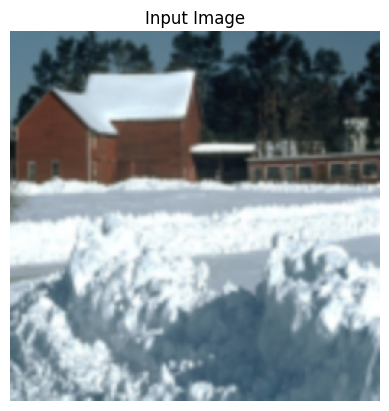

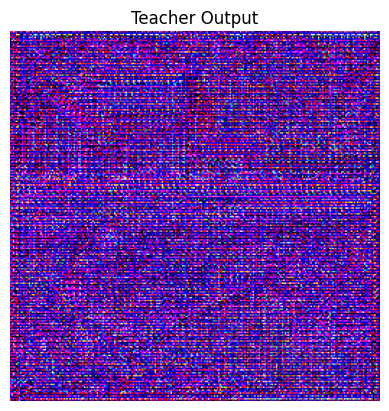

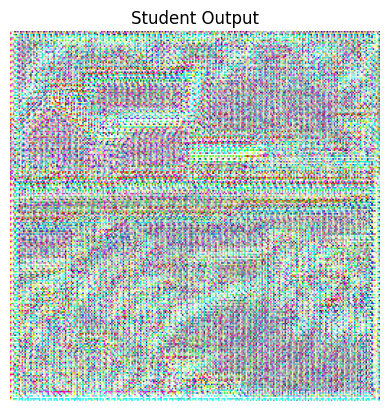

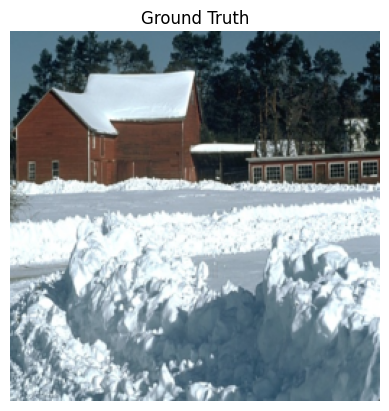

Epoch 1/10, Loss: 0.2550
Epoch 2/10, Loss: 0.2077
Epoch 3/10, Loss: 0.2011
Epoch 4/10, Loss: 0.1980
Epoch 5/10, Loss: 0.1951


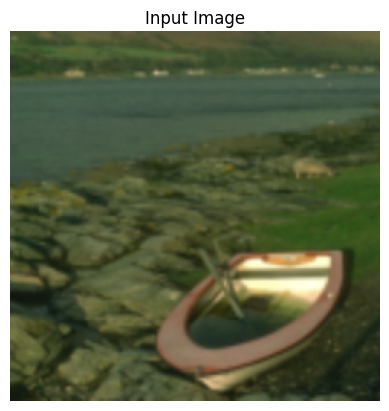

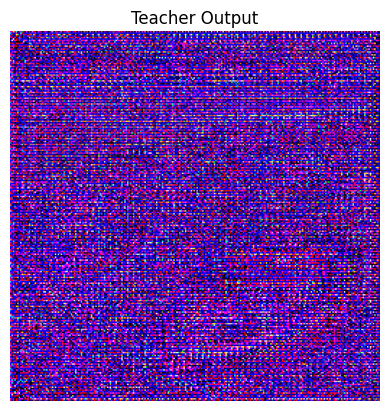

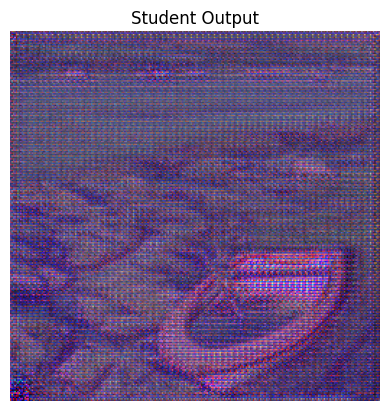

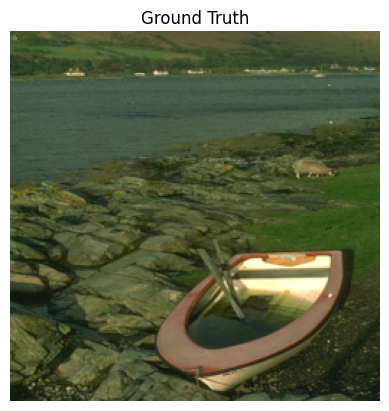

Epoch 6/10, Loss: 0.1938
Epoch 7/10, Loss: 0.1921
Epoch 8/10, Loss: 0.1909
Epoch 9/10, Loss: 0.1899
Epoch 10/10, Loss: 0.1890


In [18]:
# ----------------------------- #
#     RUN TRAINING LOOP
# ----------------------------- #
epochs = 10
for epoch in range(epochs):
    loss = train(student, teacher, train_loader, optimizer, criterion, device, epoch_idx=epoch)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    scheduler.step()  # Call scheduler step after each epoch



In [19]:
import os
from torchvision.utils import save_image

# Helper function to save images properly
def save_tensor_image(tensor, path):
    # Clamp values between 0 and 1, normalize to [0,1]
    img = tensor.detach().cpu()
    img = torch.clamp(img, 0, 1)
    save_image(img, path)

# ----------------------------- #
#     SAVE SAMPLE OUTPUT
# ----------------------------- #
student.eval()
os.makedirs("outputs", exist_ok=True)

with torch.no_grad():
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        output = student(images)

        # Save original input image
        save_tensor_image(images[0], f"outputs/original_{i}.png")

        # Save student output image (cleaned)
        save_tensor_image(output[0], f"outputs/cleaned_{i}.png")

        # Optional: Save ground truth if available
        if targets is not None:
            save_tensor_image(targets[0], f"outputs/groundtruth_{i}.png")

        print(f"Saved sample {i} images: original, cleaned" + (", groundtruth" if targets is not None else ""))

        if i == 2:  # Save 3 examples
            break


Saved sample 0 images: original, cleaned, groundtruth
Saved sample 1 images: original, cleaned, groundtruth
Saved sample 2 images: original, cleaned, groundtruth
